## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
# if not os.path.exists('sonnets.txt'):
#     !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

# with open('sonnets.txt', 'r') as iofile:
#     text = iofile.readlines()
    
# TEXT_START = 45
# TEXT_END = -368
# text = text[TEXT_START : TEXT_END]
# assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# # Join all the strings into one and lowercase it
# # Put result into variable text.

# # Your great code here
# text = ''.join(text).lower()

# assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
# assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
# print('OK!')

### Data loading: "Евгений Онегин"


В данной работе я решил использовать текст поэмы "Евгений Онегин"

In [2]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2023-12-13 13:11:32--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256,37K  --.-KB/s    in 0,07s   

2023-12-13 13:11:33 (3,76 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

In [4]:
'''
Кроме того, можно убрать из текста латинские буквы, 
которыми обозначаются номера частей и лишние знаки переноса на новую строку
'''

import re
text = re.sub("[i|v|x|c|]", '', text)
text = re.sub("\n+", '\n', text)
text[:500]

'\n«мой дядя самых честных правил,\nкогда не в шутку занемог,\nон уважать себя заставил\nи лучше выдумать не мог.\nего пример другим наука;\nно, боже мой, какая скука\nс больным сидеть и день и ночь,\nне отходя ни шагу прочь!\nкакое низкое коварство\nполуживого забавлять,\nему подушки поправлять,\nпечально подносить лекарство,\nвздыхать и думать про себя:\nкогда же черт возьмет тебя!»\nтак думал молодой повеса,\nлетя в пыли на почтовых,\nвсевышней волею зевеса\nнаследник всех своих родных. —\nдрузья людмилы и русла'

Put all the characters, that you've seen in the text, into variable `tokens`.

In [5]:
'''
Создадим множество всевозможных символов, которые встречаются в тексте.
Таким образом, в этом контейнере мы получим только уникальные символы.
'''
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
import numpy as np
'''
Занумеруем встречающиеся символы и создадим 2 слваря взаимно-обратного отображения.
Определенному символу соответствует определенное число,
Определенному числу соответствует определенный символ.
'''

# dict <index>:<char>
# Your great code here
tokens_list = list(tokens)
token_to_idx = {c:i for i, c in enumerate(tokens_list)}

# dict <char>:<index>
# Your great code here
idx_to_token = {i:c for i, c in enumerate(tokens_list)}

num_of_tokens = len(tokens_list)

# с помощью отображения закодируем текст поэмы и представим его в виде массива чисел, 
# в этом представлении с ним уже может работать компуктер
#! этот массив был нужен, когда использовалась кастомная функция генерации батчей
encoded = np.array([token_to_idx[c] for c in text], dtype=np.int32)

In [8]:
'''
Напишем функцию, которая выбирает батчи последовательностей из текста.

Here I tried to implement my own batch generation function. It worksm but worse
than DataLoader from torch. Actually, I'm still not good in it.
'''
def get_batches(arr, n_seqs, n_steps):
    '''Создаем генератор, который возвращает пакеты размером
       n_seqs x n_steps из массива arr.
       
       Аргументы
       ---------
       arr: Массив, из которого получаем пакеты
       n_seqs: Batch size, количество последовательностей в пакете
       n_steps: Sequence length, сколько "шагов" делаем в пакете
    '''
    # Считаем количество символов на пакет и количество пакетов, которое можем сформировать
    characters_per_batch = n_seqs * n_steps
    n_batches = len(arr)//characters_per_batch
    
    # Сохраняем в массиве только символы, которые позволяют сформировать целое число пакетов
    arr = arr[:n_batches * characters_per_batch]
    
    # Делаем reshape 1D -> 2D, используя n_seqs как число строк, как на картинке
    arr = arr.reshape((n_seqs, -1))
    
    for n in range(0, arr.shape[1], n_steps):
        # пакет данных, который будет подаваться на вход сети
        x = arr[:, n:n+n_steps]
        # целевой пакет, с которым будем сравнивать предсказание, получаем сдвиганием "x" на один символ вперед
        y = np.zeros_like(x)
        y[:, :-1], y[:, -1] = x[:, 1:], x[:, 0]
        yield x, y

In [9]:
from torch.utils.data import DataLoader
import torch

'''
Вместо кастомной функции генерации батчей воспользуемся готовым функционалом DataLoader
'''
class Dataset(torch.utils.data.Dataset):
    def __init__(self, sequence_length=10):
        self.sequence_length = sequence_length
        self.text = [token_to_idx[c] for c in text]
    def __len__(self):
        return len(self.text) - self.sequence_length
    def __getitem__(self, index):
        return (
            torch.tensor(self.text[index:index+self.sequence_length]),
            torch.tensor(self.text[index+1:index+self.sequence_length+1]),
        )

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [10]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
'''
Напишем класс сверточной нейронной сети.
Используем класс обычной рекурентной нейронной сети.
'''

# Your code here
class CharRNNCell(nn.Module):
    '''
    В конструктор передаем мощность алфавита (количество токенов),
    размер вектора, который будет представлять наш контекст -- embedding_size,
    длинну последовательности букв, которая будет обрабатываться на каждом этапе рекурсии (по умолчанию -- последовательность из 10 букв)
    '''
    def __init__(self, num_tokens=num_of_tokens, embedding_size=70, sequence_length=10):
        super(self.__class__,self).__init__()
        self.sequence_length = sequence_length
        
        self.embedding = nn.Embedding(num_tokens, embedding_size) # преобразование, которое переводит слово в вектор контекста
        self.rnn_update = nn.Linear(embedding_size + sequence_length, sequence_length) # линейное преобразование, которое применяется к конкатенации новго слова и прошлого контекста
        self.rnn_to_logits = nn.Linear(sequence_length, num_tokens) # трансляция полученного вектора в вектор логитов
        
    def forward(self, x, h_prev):
        '''
        Напишем функцию прямой прогонки
        '''
        x_emb = self.embedding(x) # на вход рекурентного блока мы получаем новое слово x и предыдущий вектор контекста; новое слово мы должны превратить в вектор
        x_and_h = torch.cat([x_emb, h_prev], dim=1) # конкотенируем полученный вектор и вектор контекста
        h_next = self.rnn_update(x_and_h) # применяем линейное преобразование
        h_next = torch.tanh(h_next) # применяем нелинейное преобразование
        logits = self.rnn_to_logits(h_next) # перегоняем вектор контекста в вектор логитов
        return F.log_softmax(logits, -1), h_next # возвращаем "вероятности" логитов и новый вектр контекста
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.sequence_length, requires_grad=True)

In [11]:
'''
Раньше батч представлял собой набор векторов и, таким образом, получалась матрица чисел.
Сейчас батч -- есть набор последовательностей, причем обучение на одной последовательности состоит в том,
что для очередной буквы в последовательности мы пытаемся предсказать следующую.
Таким оборазом, каждую последовательность в батче необходимо обрабатывать отдельно.

Напишем функцию для обучения на одном батче
'''
def rnn_loop(rnn_model, batch):
    batch_size, max_length = np.shape(batch)

    # инициализируем начальное состояние
    hid_state = rnn_model.initial_state(batch_size)
    logprobs = []

    for x_t in batch.T:
        logp_next, hid_state = rnn_model(torch.tensor(x_t), torch.tensor(hid_state))
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [12]:
# обучим модель
rnn = CharRNNCell()
optimizer = optim.Adam(rnn.parameters(), lr=0.001)
criterion = nn.NLLLoss()

n_epoch = 20
sequence_length = 15
batch_size = 128
history = []

dataset = Dataset(sequence_length=sequence_length)
dataloader = DataLoader(dataset, batch_size=batch_size)

In [13]:
# Your plot code here
rnn.train()
for epoch in range(n_epoch):
    h = rnn.initial_state(sequence_length)
    #! Previous it used a custom batch generator, but now we use DataLoader
    # for batch_obj, batch_labels in get_batches(encoded, batch_size, sequence_length):
    for batch_obj, batch_labels in dataloader:
        # обучаемся на батче
        predictions_logp = rnn_loop(rnn, batch_obj)
        actual_next_tokens = torch.LongTensor(batch_labels)
        # сравниваем предсказанные символы с метками обучения
        loss = criterion(
          predictions_logp.contiguous().view(-1, len(tokens)),
          actual_next_tokens.contiguous().view(-1)
        )
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    history.append(loss.item())

/tmp/ipykernel_3509724/1607109532.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logp_next, hid_state = rnn_model(torch.tensor(x_t), torch.tensor(hid_state))


Text(0, 0.5, 'Loss value')

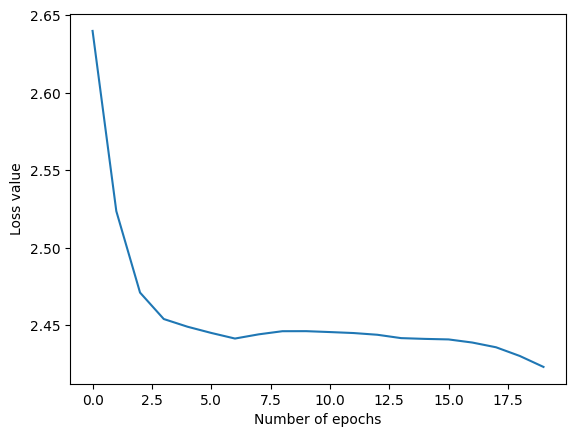

In [14]:
import matplotlib.pyplot as plt
plt.plot(history)
plt.xlabel('Number of epochs')
plt.ylabel('Loss value')

In [15]:
def generate_sample(char_rnn, seed_phrase='мой дядя', max_length=100, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        # print(x_sequence[:, -1].shape, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        # print(x_sequence.shape, x_sequence, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        # print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        # print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
 
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [16]:
# An example of generated text.
print(generate_sample(rnn, seed_phrase='так думал'))

так думалде нае пошит вно ей тачю оноща до ужетой кный, быт нвлостноют!»
чем свет жею,
тус-те,
вся т


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [17]:
# Your beautiful code here
class LSTM(nn.Module):
    def __init__(self, num_of_tokens=num_of_tokens, embedding_size=128, num_layers=1):
        super(self.__class__, self).__init__()
        self.embedding_size = embedding_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(num_of_tokens, self.embedding_size)
        self.lstm = nn.LSTM(
            input_size=self.embedding_size,
            hidden_size=self.embedding_size,
            num_layers=self.num_layers # number of recurent layers (by default 1; it need to build deep recurent networks)
        )
        self.rnn_to_logit = nn.Linear(self.embedding_size, num_of_tokens)

    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        output, h_next = self.lstm(x_emb, h_prev)
        logits = self.rnn_to_logit(output)
        return logits, h_next
    
    def initial_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.embedding_size),
                torch.zeros(self.num_layers, sequence_length, self.embedding_size))

In [18]:
model = LSTM()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

history = []

dataset = Dataset(sequence_length=sequence_length)
dataloader = DataLoader(dataset, batch_size=batch_size)

In [19]:
model.train()
for epoch in range(n_epoch):
    (h, c) = model.initial_state(sequence_length)
    #! Previous it used a custom batch generator, but now we use DataLoader
    # for batch_obj, batch_labels in get_batches(encoded, batch_size, sequence_length):
    for batch_obj, batch_labels in dataloader:
        optimizer.zero_grad()
        y_pred, (h, c) = model(torch.LongTensor(batch_obj), (h, c))
        loss = criterion(y_pred.transpose(1, 2), torch.LongTensor(batch_labels))
        h.detach_()
        c.detach_()
        loss.backward()
        optimizer.step()
    history.append(loss.item())

Text(0, 0.5, 'Loss value')

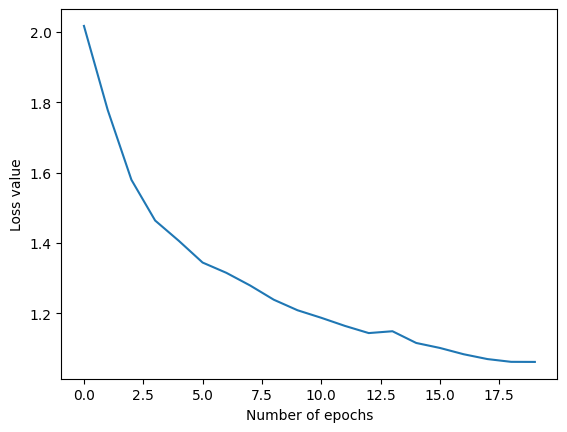

In [20]:
plt.plot(history)
plt.xlabel('Number of epochs')
plt.ylabel('Loss value')

In [21]:
def generate_sample(model, seed_phrase=' ', max_length=100, temperature=0.2):
    model.eval()
    h, c = model.initial_state(len(seed_phrase))
    for i in range(0, max_length):
        x = torch.tensor([[token_to_idx[c] for c in seed_phrase[i:]]])
        y_pred, (h, c) = model(x, (h, c))
        last_char_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_char_logits / temperature, dim=0).detach().numpy()
        char_index = np.random.choice(len(last_char_logits), p=p)
        seed_phrase = seed_phrase + idx_to_token[char_index]
    return seed_phrase

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [22]:
# Text generation with different temperature values here
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
for temp in temperatures:
    print(f"text generation with temperature T = {temp}")
    print(generate_sample(model, seed_phrase='мой дядя', temperature=temp, max_length=200))
    print()

text generation with temperature T = 0.1
мой дядя!
к мой должны привычный страсти,
и в старый ваш привычный странный,
и в старик, так в сердце в старинный,
и в сердце тани с ней не мог.
l
его был он молодой дале
и в старом страсти с какой-то лет,
и 

text generation with temperature T = 0.2
мой дядя.
быть может, я встречает с ней.
l
онегин в свете молодой,
и в самим сердцем привычит и
встречает с свой привычной света
с корованный в света благода,
как будто б не мог она мог
она в сердце страстей 

text generation with temperature T = 0.5
мой дядя!» – – «окомного
с корость и страсти странной средь.
l
так ты же страстей на мой вас
в вышели с корозной днен,
и в самир, так в темных строгий
пред ней ни мог он моей поднять
и просто с вами страшный 

text generation with temperature T = 1.0
мой дядяm. – «        -тоб прина.
и, между лист, одною такы
иль явал очаровный взможе,
так я я русский дили томтань…
вот ша ток, было жар бустях,
всеган влешибу света постей
прибед находят в деси: мой!»… a€

### Вывод
Как видно, по сравнению с обычным рекурентным блоком LSTM показывает лучшие результаты. Благодаря механизму "долгосрочной памяти" модель выдает по большей части последовательности настоящих осмысленных слов, а не просто наборы букв, которые похожи на слова. 
Можно пронаблюдать, как значение temperature влияет на разнообразие генерации. Из наблюдений можно сделать вывод, что лучше всего применять среднее значение температуры. При слишком низком значении генерации становятся топорными и мало изменяются от запусука к запуску. При слишком высокой температуре модель начинает выдавать какой-то совершенный хаос.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [23]:
# Как можно сохранить обученную модель в файл
#! Внимание, путь к папке сохранения захардкожен для моего компьютера
path_to_save = '/home/pavel/workdir/remote_work/ml-course-home-tasks/homeworks/lab02_deep_learning'
file_to_save = 'model'
torch.save(model.state_dict(), path_to_save + '/' + file_to_save)

In [24]:
copy_model = LSTM()
copy_model.load_state_dict(torch.load(path_to_save + '/' + file_to_save))
print(generate_sample(copy_model, temperature=0.5, seed_phrase='как рано мог уж он тревожить', max_length=200))

как рано мог уж он тревожить! – «как ты с том,
в пред след, прошла всегда преданно,
и встречает с светской полей
и представить не долгою бурил,
она в может я был он отворят,
и в старины милый то влеке
в то крестной я был давал п


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)